In [105]:

import numpy as np 
import matplotlib.pyplot as plt


def FastIAST(P_gas,T,y1,y2,y3,y4,y5):
    IP1_CH4                               = 0.0016     #kmol/kg
    IP2_CH4                               = 0          #1/bar
    IP3_CH4                               = 4.2E-05    #1/bar
    IP4_CH4                               = 2922.78    #K

    IP1_C2H6                              = 0.0027     #kmol/kg
    IP2_C2H6                              = 0.0        #1/bar 
    IP3_C2H6                              = 2.66E-04   #1/bar
    IP4_C2H6                              = 2833.77    # K

    IP1_C3H8                              = 0.0062     #kmol/kg
    IP2_C3H8                              = 0.0        #1/bar 
    IP3_C3H8                              = 3.75E-04   #1/bar
    IP4_C3H8                              = 2795.28    #K

    IP1_C4H10                             = 0.007      #kmol/kg
    IP2_C4H10                             = 0.0        #1/bar 
    IP3_C4H10                             = 0.0015     #1/bar
    IP4_C4H10                             = 2600       #K

    IP1_CO2                               = 0.0028     #kmol/kg
    IP2_CO2                               = 0.0        #(kmol/kg)/bar 
    IP3_CO2                               = 0.000748   #1/bar
    IP4_CO2                               = 2084.44    #K

    IP1_N2                                = 0.0075     #kmol/kg
    IP2_N2                                = 0.0        #(kmol/kg)/bar 
    IP3_N2                                = 0.00099    #1/bar
    IP4_N2                                = 935.77     #K
    
    Q1 = IP1_CH4 - IP2_CH4*T # Isotherm max capacity CH4
    Q2 = IP1_C2H6 - IP2_C2H6*T # Isotherm max capacity C2H6
    Q3 = IP1_C3H8 - IP2_C3H8*T # Isotherm max capacity C3H8
    Q4 = IP1_C4H10 - IP2_C4H10*T # Isotherm max capacity C4H10
    Q5 = IP1_CO2 - IP2_CO2*T # Isotherm max capacity CO2
    Q6 = IP1_N2 - IP2_N2*T  # Isotherm max capacity N2


    b1 = IP3_CH4*np.exp(IP4_CH4/T) # Isotherm affinity coeff. CH4
    b2 = IP3_C2H6*np.exp(IP4_C2H6/T) # Isotherm affinity coeff. C2H6
    b3 = IP3_C3H8*np.exp(IP4_C3H8/T) # Isotherm affinity coeff. C3H8
    b4 = IP3_C4H10*np.exp(IP4_C4H10/T) # Isotherm affinity coeff. C4H10
    b5 = IP3_CO2*np.exp(IP4_CO2/T) # Isotherm affinity coeff. CO2
    b6 = IP3_N2*np.exp(IP4_N2/T) # Isotherm affinity coeff. N2
    error = 0 # 1 - there was an error in the programm, 0 - OK
    N = 5 # Number of components
    #Langmuir Isotherm
    SingleComponentCapacity = np.array([Q1,Q2,Q3,Q4,Q5]) #Langmuir Isotherm capacity of every component
    AffinityCoefficient = np.array([b1,b2,b3,b4,b5]) #Langmuir Affinity Coefficient of every component
    fractionGas = np.array([y1,y2,y3,y4,y5]) #Gas fraction of every component

    #Initialization
    fastiastGraphConcentration = np.zeros(N)
    fastiastGraphFraction = np.zeros(N)
    fastiastPressure = 0
    adsorbedFraction = np.zeros(N)
    adsorbedConcentration = np.zeros(N)

    #Checking..
    if (len(fractionGas) < N or len(SingleComponentCapacity) < N or len(AffinityCoefficient) < N):
        print("You have the incorrect number of components")
        error = 1
    if np.sum(fractionGas) < 0.95 or np.sum(fractionGas) > 1.05:
        error = 1
        print("The molar fractions sum is not equal to 1")

    ###Calculation###

    kappa_old = np.zeros(N)
    delta_kappa = np.ones(N)
    kappa = np.zeros(N)
    CmuT = 0

    partialPressureComponents = fractionGas*P_gas
    for k in range(N):
        CmuT += SingleComponentCapacity[k]*AffinityCoefficient[k]*partialPressureComponents[k]

    for k in range(N):
        kappa[k] = CmuT/(SingleComponentCapacity[k])

    i = 0
    while np.any((delta_kappa) > 1e-4):
        f = np.zeros(N)
        fDerivative = np.zeros(N)
        g = np.zeros(N)
        sigma = np.zeros(N)
        phi = np.zeros((N,N))
        phi = np.matrix(phi)

        for k in range(N):
            f[k] = SingleComponentCapacity[k]*(np.log(1+kappa[k]))
            fDerivative[k] = SingleComponentCapacity[k]*(1/(1+kappa[k]))

        for k in range(N-1):
            g[k] = f[k] - f[k+1]
        for k in range(N):
            g[N-1] += AffinityCoefficient[k]*partialPressureComponents[k]/kappa[k]
        g[N-1] = g[N-1] - 1 


        for k in range(N-1):
            phi[k,k] = fDerivative[k]
            phi[k,k+1] = -fDerivative[k+1]
        for k in range(0,N):
            phi[N-1,k] = - (AffinityCoefficient[k]*partialPressureComponents[k]/(kappa[k]**2))

        sigma = np.linalg.solve(phi, g)
        kappa_old = kappa
        kappa = kappa_old - sigma

        delta_kappa = np.abs(kappa-kappa_old)


        i += 1
        if i > 20 or np.any(kappa<0):
            print("No convergence")
            error = 1
            break
        if np.any(kappa < 0):
            print("No convergence")
            error = 1
            break
        adsorbedFraction = partialPressureComponents*AffinityCoefficient/kappa
        adsorbedConcentrationPure = SingleComponentCapacity*(kappa
                                      /(1+kappa))  
        
        C_total = 0
        for k in range(0,N):
            C_total += ( (adsorbedFraction[k]) / adsorbedConcentrationPure[k])
        C_total = 1/C_total
        adsorbedConcentration =  C_total*adsorbedFraction   

    fastiastGraphConcentration=np.vstack((fastiastGraphConcentration, adsorbedConcentration))
    fastiastGraphFraction=np.vstack((fastiastGraphFraction, adsorbedFraction))
    fastiastPressure=np.vstack((fastiastPressure, P_gas))
    if error == 0:
    ###Result###
        return(fastiastGraphConcentration[1,:])
    else:
        return(0)

FastIAST(0.5,303,0.5,0.1,0.1,0.2,0.1) 


array([2.74315995e-05, 1.02110541e-04, 5.39011960e-04, 2.68774300e-03,
       2.61690290e-05])

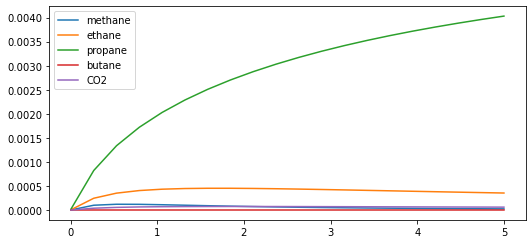

In [123]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
resultPlot = np.zeros(5)

P = np.linspace(0.005,5,20)
for P_gas in P:
    resultPlot = np.vstack((resultPlot, FastIAST(P_gas,298,0.6,0.15,0.15,0.0,0.1)))
plt.plot(P,resultPlot[1:,0], label = "methane")
plt.plot(P,resultPlot[1:,1], label = "ethane")
plt.plot(P,resultPlot[1:,2], label = "propane")
plt.plot(P,resultPlot[1:,3], label = "butane")
plt.plot(P,resultPlot[1:,4], label = "CO2")
plt.legend()
